# Анализ лояльности пользователей Яндекс Афиши

### Цели и задачи проекта


**Цель:** Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - изучить данные более детально;
    - исследование признаков, влияющих на совершение повторного заказа пользователями
4. Сформулировать выводы по проведённому анализу.

### Содержимое проекта

1. Загрузка данных и их предобработка
2. Предобработка данных.
3. Создание профиля пользователя.
4. Исследовательский анализ данных.
5. Общий вывод и рекомендации.
6. Финализация проекта и публикация в Git

---

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные.

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Создаем строку для подключения к базе данных
!pip install python-dotenv

import os
from dotenv import load_dotenv

load_dotenv()

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

In [3]:
# Создадим соединение
engine = create_engine(connection_string)

Извлечем результаты sql-запроса

In [4]:
# Запишем запрос в переменную query
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) as days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
    JOIN afisha.events e ON p.event_id = e.event_id
    JOIN afisha.city c ON e.city_id = c.city_id
    JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id;
'''

In [5]:
# Записываем результат выдачи SQL-запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Познакомимся с данными датафрейма df — выведем первые строки методом head(), а информацию о датафрейме методом info():

In [6]:
# Выводим информацию о датафрейме `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [7]:
# Выводим первые строки датафрейма `df` на экран
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


### Промежуточный вывод

Датасет `df` содержит 15 столбцов и 290611 строк, в которых представлена информация о покупках пользователей сервиса Яндекс Афиша.


После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов в формате snake_case, менять названия не будем.
- Выгрузка данных прошла корректно, представлены все нужные по заданию 15 столбцов. В первоначальных данных до формирования sql-запроса для задачи самое большое количество строк было в таблице purchases (292034). В результате выгрузки получили сопоставимое количество строк(290611).
- Данные представлены следующими типами:
    - **Числовые значения с плавающей запятой (float64).** Два столбца представлены типом `float64` - это `revenue`, `days_sins_prev`. Тип `float64` для столбца `revenue` корректен, однако можно уменьшить разрядность до `float32`. Для стобца `days_sins_prev` больше подойдет целочисленный тип данных `int16`, по условию это целое количество дней.
    - **Строковые данные (object).** Восемь столбцов имеют тип данных `object` - это `user_id`, `device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `region_name`, `city_name`. Эти столбцы содержат строковую информацию, тип данных `object` подходит.
    - **Целочисленные значения (int64).** Три столбца имеют тип данных `int64` - это `order_id`, `tickets_count`, `event_id`. Целочисленный тип данных корректен, но для оптимизации можно уменьшить разрядность.
    - **Типы даты и времени (datetime64[ns]).** Два столбца представлены типом `datetime64[ns]` - это `order_dt`, `order_ts`. Столбцы `order_ts`, `order_dt`содержат информацию о дате и времени создания заказа, тип `datetime64[ns]` подходит.
- Пропуски содержатся в столбце `days_sins_prev`(21933 пропусков). Это особенность данных, нет информации для пользователей, совершивших только одну покупку.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [8]:
# Создаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
tmp = df.copy() 
len(tmp)

290611

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Проверим данные на дубликаты

In [9]:
# Проверяем полные дубликаты в датафрейме df
df.duplicated().sum()

0

В датафрейме нет полных дубликатов строк.

Проверим неявные дубликаты — значения по order_id должны быть уникальными.

In [10]:
# Проверяем неявные дубликаты в датафрейме df в столбце 'order_id'
df.duplicated(subset='order_id').sum()

0

Все номера заказов уникальны

Проверим возможное задвоение заказов при технической ошибке(если order_id разный, но одинаковый user_id, order_ts, revenue_rub, device_type_canonical, event_id).

In [11]:
# Проверяем дубликаты в датафрейме df по совпадению в столбцах 'user_id', 'event_id', 'revenue_rub', 'order_ts', 'device_type_canonical'
df.duplicated(subset=['user_id', 'event_id', 'revenue', 'order_ts', 'device_type_canonical']).sum()

42

Получили 42 дубликата по совпадению идентификатора пользователя, времени заказа, устройства, с которого совершался заказ, выручки и идентификатора события.

In [12]:
# Выводим дубликаты для изучения
duplicates = df[df.duplicated(subset=['user_id', 'event_id', 'revenue', 'order_ts', 'device_type_canonical'], keep=False)]
print(duplicates.sort_values(['user_id', 'event_id', 'revenue', 'order_ts', 'device_type_canonical']))

                user_id device_type_canonical  order_id   order_dt  \
11758   06eb7897f65b433                mobile   1123983 2024-08-13   
11759   06eb7897f65b433                mobile   1123867 2024-08-13   
26868   0dc525d7bacbb0d               desktop   1930763 2024-07-31   
26869   0dc525d7bacbb0d               desktop   1930705 2024-07-31   
53681   206ea45ec11d478                mobile   1935113 2024-10-29   
...                 ...                   ...       ...        ...   
285379  fd4d47438ebb946               desktop   8548099 2024-06-19   
285388  fd4d47438ebb946               desktop   8547809 2024-06-19   
285375  fd4d47438ebb946               desktop   8547867 2024-06-19   
285382  fd4d47438ebb946               desktop   8548012 2024-06-19   
285383  fd4d47438ebb946               desktop   8547983 2024-06-19   

                  order_ts currency_code  revenue  tickets_count  \
11758  2024-08-13 16:31:07           rub    69.82              1   
11759  2024-08-13 16:31

In [13]:
# Удаляем дубликаты
df = df.drop_duplicates(subset=['user_id', 'event_id', 'revenue', 'order_ts', 'device_type_canonical'])

В результате проверки на дубликаты:

    - Явных дубликатов не выявлено
    - Удалено 42(0.01%) строки неявных дубликатов по совпадению идентификатора пользователя, времени заказа, устройства, с которого совершался заказ, выручки и идентификатора события.

In [14]:
# Выгружаем данные о курсе казахстанского тенге по отношению к российскому рублю в tenge_df
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv', parse_dates=['data'])

In [15]:
# Выводим информацию о датафрейме `tenge_df`
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [16]:
# Выводим первые строки датафрейма `tenge_df` на экран
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Объединим датасеты `df` и `tenge_df` по дате заказа(столбец `order_dt`) и дате курса тенге(столбец `data`) . Предварительно проверим написание валют и приведем столбец `order_dt` к формату, содержашему только дату. Для объединения оставим только нужные столбцы(`data`, `curs`) из датасета `tenge_df`.

In [17]:
# Проверим написание валют в датасете `tenge_df`
tenge_df['cdx'].unique()

array(['kzt'], dtype=object)

In [18]:
# Проверим написание валют в датасете `df`
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

Написание курсов валют проверено, соответсвует ожиданиям, исправлять не требуется.

In [19]:
# Преобразуем дату заказа 'order_dt' к формату даты без времени
df['order_dt'] = df['order_dt'].dt.normalize()

In [20]:
# Оставляем только столбцы(`data`, `curs`) из датасета `tenge_df`
tenge_df = tenge_df[['data', 'curs']].rename(columns={'data': 'order_dt'})

In [21]:
# Объединяем датасеты 'df' и 'tenge_df' по дате
df = df.merge(tenge_df, on='order_dt', how='left')

 Приведем выручку к единой валюте — российскому рублю. Результаты преобразования сохраним в новый столбец revenue_rub.

In [22]:
# Создаем новый столбец 'revenue_rub'
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub'
                else row['revenue'] / 100 * row['curs'], axis=1
)

In [23]:
# Проверяем, что объединение и добавление столбца 'revenue_rub' прошло успешно
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290569 entries, 0 to 290568
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290569 non-null  object        
 1   device_type_canonical  290569 non-null  object        
 2   order_id               290569 non-null  int64         
 3   order_dt               290569 non-null  datetime64[ns]
 4   order_ts               290569 non-null  datetime64[ns]
 5   currency_code          290569 non-null  object        
 6   revenue                290569 non-null  float64       
 7   tickets_count          290569 non-null  int64         
 8   days_since_prev        268636 non-null  float64       
 9   event_id               290569 non-null  int64         
 10  event_name             290569 non-null  object        
 11  event_type_main        290569 non-null  object        
 12  service_name           290569 non-null  obje

Загрузили информацию о курсе казахстанского тенге по отношению к рублю за 2024 год, пересчитали выручку, используя только рубли, добавили новый столбец с выручкой только в рублях в датафрейм. В новом столбце со стоимостью в рублях пропущенных значений нет.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [24]:
# Проверяем количество пропущенных значений в данных
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
curs                         0
revenue_rub                  0
dtype: int64

Пропуски присутствуют только в столбце 'days_since_prev' в количестве 21933.

Для оптимизации уменьшим разрядность столбцов с числовыми типами данных

In [25]:
# Преобразовываем типы данных столбцов 'revenue', 'days_since_prev', 'curs', 'revenue_rub' с понижением разрядности
for column in ['revenue', 'days_since_prev', 'curs', 'revenue_rub']:
    df[column] = pd.to_numeric(df[column], downcast='float')

In [26]:
# Преобразовываем типы данных столбцов 'order_id', 'tickets_count', 'event_id' с понижением разрядности
for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')

In [27]:
# Проверяем результат преобразования
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
curs                            float32
revenue_rub                     float32
dtype: object

Изучим столбцы с категориальными данными

In [28]:
# Проверяем уникальные значения в столбцах 'device_type_canonical', 'event_type_main', 'service_name' в датафрейме 'df'
for column in ['device_type_canonical', 'event_type_main', 'service_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']



In [29]:
# Проверяем уникальные значения в столбцах 'city_name', 'region_name' в датафрейме 'df'
for column in ['city_name', 'region_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце city_name:
['Айкольск' 'Айсуак' 'Акбастау' 'Акбасты' 'Акжолтау' 'Алтынкала'
 'Алтынсай' 'Байкуль' 'Байсары' 'Байтерековск' 'Беловодск' 'Белоярск'
 'Бережанка' 'Бережанск' 'Березиногорск' 'Березиноск' 'Березовцево'
 'Берестовец' 'Берестяград' 'Берёзиново' 'Берёзовка' 'Берёзогорск'
 'Берёзодальн' 'Берёзополье' 'Берёзореч' 'Берёзоречье' 'Бозарык'
 'Боровлянск' 'Буркиттау' 'Бурьяново' 'Верховино' 'Верховка'
 'Верхозолотск' 'Верхозорье' 'Верхоозёров' 'Ветеринск' 'Вишнёво'
 'Вишнёвогорск' 'Вишнёводск' 'Водниково' 'Глиногорск' 'Глиногорь'
 'Глиноград' 'Глинозолото' 'Глинозорь' 'Глинолес' 'Глинополин'
 'Глинополье' 'Глинополянск' 'Глинореч' 'Глинянск' 'Голубевск' 'Голубино'
 'Гореловск' 'Горицветск' 'Горноград' 'Горнодолинск' 'Горнолесье'
 'Горнолуг' 'Горнополец' 'Горнополье' 'Горнополянск' 'Горнополяровск'
 'Горнополёк' 'Горноставинск' 'Горяново' 'Дальнеград' 'Дальнесветин'
 'Дальнесветск' 'Дальнесоснов' 'Дальнозелен' 'Дальнозерск' 'Дальнозолотск'
 'Дальнолесье' 

Среди названий городов и регионов есть очень похожие названия(например 'Заречийск'-'Заречинск'), но нет возможности проверить не является ли это ошибкой данных. Каких-то неожиданных значений в категориальных данных не обнаружено.

По итогу изучения уникальных значений в категориальных данных, сделан вывод, что в нормализации(приведение к нижнему регистру, удаление пробелов) нет необходимости.

Проверим распределение численных данных и наличие в них выбросов. Будем использовать статистические показатели, гистограммы распределения значений и диаграммы размаха. 

In [30]:
# Выводим статистические показатели в столбце с выручкой с заказа 'revenue_rub'
df['revenue_rub'].describe()

count    290569.000000
mean        555.586609
std         875.488037
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

Есть отрицательные значения(вероятно, это возвраты заказов). Среднее значение сильно отличается от медианного, что свидетельствует о влиянии выбросов. Максимальное значение выручки составляет 81174, что является выбросом.

Text(0, 0.5, 'Частота')

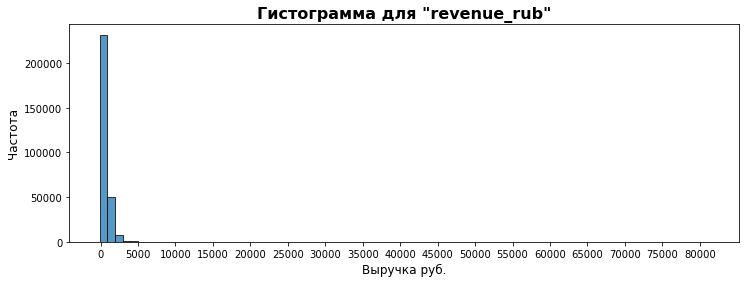

In [31]:
# Построим гистограмму для изучения распределения выручки
plt.figure(figsize=(12, 4))
sns.histplot(data=df['revenue_rub'], bins=80)
plt.xticks(np.arange(0, 82000, 5000))
plt.title('Гистограмма для "revenue_rub"', fontsize=16, fontweight='bold')
plt.xlabel('Выручка руб.', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Асимметричное распределение с длинным правым хвостом из-за выбросов. Больше всего данных о выручке сосредоточено на значениях до 5000 руб.

Text(0.5, 0, 'Выручка руб.')

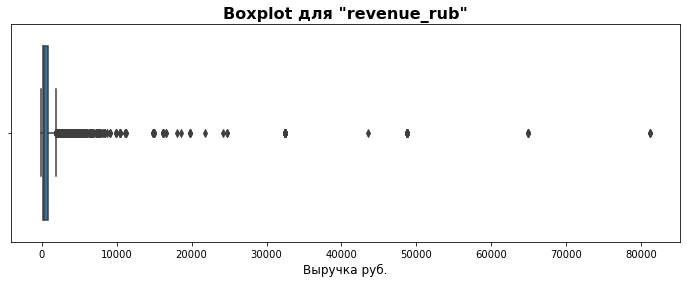

In [32]:
# Построим диаграмму размаха для 'revenue_rub'
plt.figure(figsize=(12, 4))
sns.boxplot( x=df['revenue_rub'])
plt.title('Boxplot для "revenue_rub"', fontsize=16, fontweight='bold')
plt.xlabel('Выручка руб.', fontsize=12)

Большое количество выбросов(в основном до 10000), также есть несколько значительных выбросов с выручкой более 30000 руб. Скорее всего, это заказы большого количества билетов для каких-то мероприятий в коллективах.


Крупные выбросы(особенно 81174) могут сильно искажать результаты исследования.
Отфильтруем значения по 99 перцентилю

In [33]:
# Фильтруем по 99-му перцентилю
perc99_revenue = df['revenue_rub'].quantile(0.99)
print(f"99-й перцентиль revenue_rub: {perc99_revenue:.2f} ₽")

99-й перцентиль revenue_rub: 2628.42 ₽


In [34]:
# Определяем, сколько записей будет удалено
outliers_mask = df['revenue_rub'] > perc99_revenue
sum_outliers = outliers_mask.sum()
total_rows = len(df)
perc_outliers = sum_outliers / total_rows * 100
print(f"Выбросов: {sum_outliers} строк ({perc_outliers:.2f}%)")

Выбросов: 2825 строк (0.97%)


In [35]:
# Фильтрация выбросов по 99 перцентилю
df_without_outliers = df[~outliers_mask].copy()

print(f"Размер датасета до фильтрации: {len(df)}")
print(f"Размер датасета после фильтрации: {len(df_without_outliers )}")
print(f"Удалено строк: {len(df) - len(df_without_outliers )} ({perc_outliers:.2f}%)")

Размер датасета до фильтрации: 290569
Размер датасета после фильтрации: 287744
Удалено строк: 2825 (0.97%)


В результате фильтрации по 99-перцентилю будет потеряно менее 1% строк. Допустимые потери.

In [36]:
# Сохраняем отфильтрованный датафрейм
df = df_without_outliers

Проанализируем отрицательные значения в выручке

In [37]:
# Проверяем количество отрицательных значений в выручке

negative_revenue = df[df['revenue_rub'] < 0]
count_negative = len(negative_revenue)
percent_negative = count_negative / len(df) * 100

print(f"Строк с отрицательными значениями выручки: {count_negative} ({percent_negative:.2f}%)")



Строк с отрицательными значениями выручки: 381 (0.13%)


Выявили 381 строку с отрицательными значениями выручки, что составляет 0.13% строк. Предполагаем, что это возвраты покупок. Удалим эти строки, чтобы не искажать данные по выручке. Процент потери данных приемлем.

In [38]:
# Удаляем строки с отрицательными значениями выручки
df = df[df['revenue_rub'] >= 0].reset_index(drop=True)


In [39]:
# Выводим статистические показатели по столбцу 'tickets_count'
df['tickets_count'].describe()

count    287363.000000
mean          2.741324
std           1.163067
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

Среднее значение заметно отличается от медианного, что свидетельствует о влиянии выбросов. Максимальное значение количества купленных билетов 57, что является выбросом.

Text(0, 0.5, 'Частота')

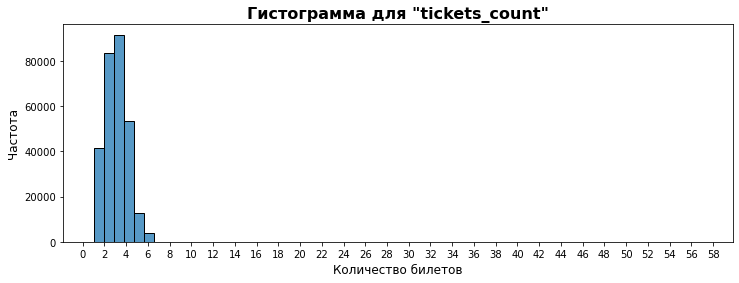

In [40]:
# Построим гистограмму для изучения распределения количества купленных билетов
plt.figure(figsize=(12, 4))
sns.histplot(data=df['tickets_count'], bins=60)
plt.xticks(np.arange(0, 60, 2))
plt.title('Гистограмма для "tickets_count"', fontsize=16, fontweight='bold')
plt.xlabel('Количество билетов', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Чаще всего покупают небольшое количество билетов(до 5 штук). Асимметричное распределение с длинным правым хвостом из-за выбросов.

Text(0.5, 0, 'Количество билетов')

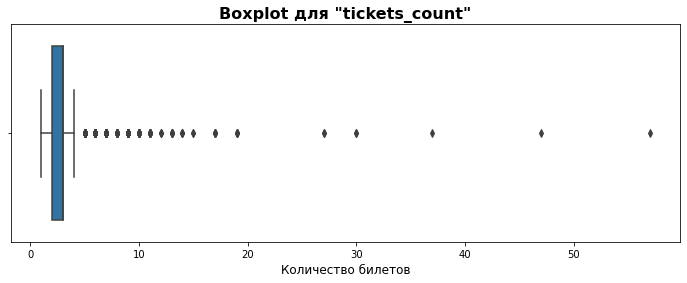

In [41]:
# Построим диаграмму размаха для 'tickets_count'
plt.figure(figsize=(12, 4))
sns.boxplot( x=df['tickets_count'])
plt.title('Boxplot для "tickets_count"', fontsize=16, fontweight='bold')
plt.xlabel('Количество билетов', fontsize=12)

Присутсвует несколько выбросов. Самый значительный выброс - 57 билетов. Выбросы могут быть связаны с закупками билетов для коллективов.

days_since_prev

In [42]:
# Выводим статистические показатели по столбцу 'days_since_prev'
df['days_since_prev'].describe()

count    265663.000000
mean          3.225481
std          11.350803
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

Медианное и среднее значения значительно отличаются. Максимальное количество дней между заказами 148, это выброс. Медианное значение равно 0.000000, значит, часто повторный заказ оформляли в тот же день.

Text(0, 0.5, 'Частота')

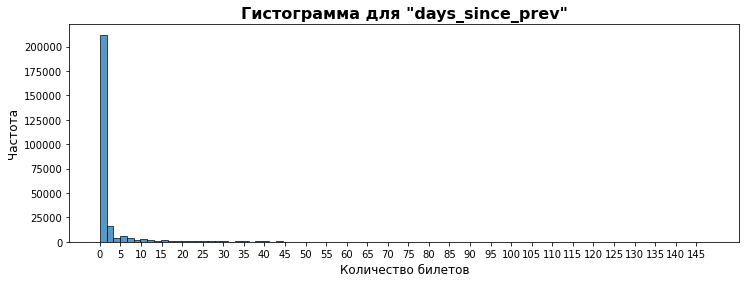

In [43]:
# Построим гистограмму для изучения распределения количества купленных билетов
plt.figure(figsize=(12, 4))
sns.histplot(data=df['days_since_prev'], bins=90)
plt.xticks(np.arange(0, 150, 5))
plt.title('Гистограмма для "days_since_prev"', fontsize=16, fontweight='bold')
plt.xlabel('Количество билетов', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Между повторными покупками чаще всего проходило не более 2х дней. Асимметричное распределение с длинным правым хвостом из-за выбросов.

Text(0.5, 0, 'Кол-во дней от предыдущей покупки пользователя')

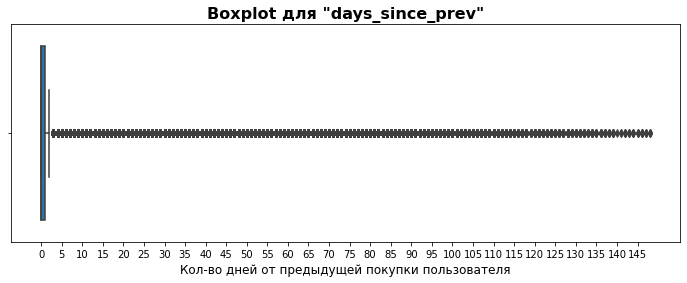

In [44]:
# Построим диаграмму размаха для 'days_since_prev'
plt.figure(figsize=(12, 4))
sns.boxplot( x=df['days_since_prev'])
plt.xticks(np.arange(0, 150, 5))
plt.title('Boxplot для "days_since_prev"', fontsize=16, fontweight='bold')
plt.xlabel('Кол-во дней от предыдущей покупки пользователя', fontsize=12)

Сама коробка расположена в районе нуля. Очень большое количество выбросов.

In [45]:
# Проверим сколько удалено строк датасета
a, b = len(tmp), len(df)
print(" Было строк в исходном датасете", a,
      '\n', "Осталось строк в датасете после обработки", b,
      '\n', "Удалено строк в датасете после обработки", a-b,
      '\n', "Процент потерь", round((a-b)/a*100, 2))

 Было строк в исходном датасете 290611 
 Осталось строк в датасете после обработки 287363 
 Удалено строк в датасете после обработки 3248 
 Процент потерь 1.12


## Промежуточный вывод

1. Проверили данные на дубликаты

    - Явных дубликатов не выявлено
    - Удалено 42(0.01%) строки неявных дубликатов по совпадению идентификатора пользователя, времени заказа, устройства, с которого совершался заказ, выручки и идентификатора события.


2. Загрузили информацию о курсе казахстанского тенге по отношению к рублю за 2024 год, пересчитали выручку, используя только рубли, добавили новый столбец 'revenue_rub' с выручкой только в рублях.


3. Проверили данные на пропущенные значения:

    - Пропуски присутствуют только в столбце 'days_since_prev' в количестве 21933. Это соответсвует условиям исследования, так как не все пользователи совершали повторные покупки.
    

4. Преобразовали числовые типы данных с понижением разрядности:

      - Тип данных столбцов 'revenue', 'days_since_prev', 'curs', 'revenue_rub' был преобразован с 'float64' до 'float32'.
      - Типы данных столбцов 'order_id', 'event_id' преобразованы из 'int64' в 'int32'
      - Тип данных 'tickets_count' преобразованы из 'int64' в 'int8'
      
      
5. Проверили категориальные данные:

    - Значений, обозначающих пропуски или отсутствие информации, не обнаружено.
    
    
6. Проверим распределение численных данных и наличие в них выбросов:

     - Результат исследования столбца 'revenue_rub': 
         - Есть отрицательные значения(вероятно, это возвраты заказов)
         - Удалили отрицательные значения
         - Среднее значение сильно отличается от медианного
         - Максимальное значение выручки составляет 81174, что является выбросом
         - Отфильтровали выбросы по 99 перцентилю
         - В результате удалено 2825 строк (0.97%)
     - Результат исследования столбца tickets_count':
         - Среднее значение заметно отличается от медианного
         - Максимальное значение количества купленных билетов 57, что является выбросом
     - Результат исследования столбца 'days_since_prev':
        - Медианное и среднее значения значительно отличаются
        - Максимальное количество дней между заказами 148, это выброс
        - Между повторными покупками чаще всего проходило не более 2х дней
 
 
 7. По итогу предобработки данных удалено 3248 строк (1.12%)

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Отсортируем данные в датафрейме по времени совершения заказа. Затем создадим профиль пользователя, используя группировку и агрегацию

In [46]:
# Сортируем данные по времени совершения заказа
df = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

In [47]:
# Создаем профиль пользователя с необходимыми параметрами
user_profile = df.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    device_first=('device_type_canonical', 'first'),
    region_first=('region_name', 'first'),
    service_first=('service_name', 'first'),
    event_type_first=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', lambda x: x.dropna().mean() if x.dropna().size > 0 else np.nan)
).reset_index()

Добавляем в профиль пользователя бинарные признаки (is_two — совершил ли пользователь 2 и более заказа, is_five — совершил ли пользователь 5 и более заказов.)

In [48]:
# Добавляем бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

Проверяем получившийся профиль пользователя. Для выведем информацию о датафрейме.

In [49]:
# Выводим информацию о user_profile
user_profile.info()
print(f'\nВ user_profile {user_profile.shape[0]} строк и {user_profile.shape[1]} столбцов ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           21838 non-null  object        
 1   first_order_date  21838 non-null  datetime64[ns]
 2   last_order_date   21838 non-null  datetime64[ns]
 3   device_first      21838 non-null  object        
 4   region_first      21838 non-null  object        
 5   service_first     21838 non-null  object        
 6   event_type_first  21838 non-null  object        
 7   total_orders      21838 non-null  int64         
 8   avg_revenue_rub   21838 non-null  float32       
 9   avg_tickets       21838 non-null  float64       
 10  avg_days_between  13504 non-null  float64       
 11  is_two            21838 non-null  int32         
 12  is_five           21838 non-null  int32         
dtypes: datetime64[ns](2), float32(1), float64(2), int32(2), int64(1), object(5)


Получили датафрейм с профилем пользователя, в котором содердится 21838 строк и 13 столбцов.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

Проверим данные в датафрейме user_profile на аномалии и репрезентативность

In [50]:
#  Считаем общее количество пользователей
total_users = user_profile['user_id'].nunique()

In [51]:
# Считаем среднюю выручку с одного заказа
avg_revenue_order = user_profile['avg_revenue_rub'].mean()

In [52]:
# Считаем долю пользователей, совершивших 2 и более заказа
share_is_two = user_profile['is_two'].mean()

In [53]:
# Считаем долю пользователей, совершивших 5 и более заказов
share_is_five = user_profile['is_five'].mean()

In [54]:
# Выводим результаты расчетов метрик
print(f"Общее число пользователей: {total_users:}")
print(f"Средняя выручка с одного заказа: {avg_revenue_order:.2f} ₽")
print(f"Доля пользователей, совершивших 2 и более заказа: {share_is_two:.2%}")
print(f"Доля пользователей, совершивших 5 и более заказов: {share_is_five:.2%}")


Общее число пользователей: 21838
Средняя выручка с одного заказа: 545.03 ₽
Доля пользователей, совершивших 2 и более заказа: 61.70%
Доля пользователей, совершивших 5 и более заказов: 28.99%


Изучим статистические показатели: по общему числу заказов, по среднему числу билетов в заказе, по среднему количеству дней между покупками.

In [55]:
# Выводим статистические показатели
user_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)

,total_orders,avg_tickets,avg_days_between
count,21838.00,21838.00,13504.00
mean,13.16,2.74,15.87
std,121.56,0.91,22.33
min,1.00,1.00,0.00
25%,1.00,2.00,1.00
50%,2.00,2.75,8.00
75%,5.00,3.08,20.50
max,10168.00,11.00,148.00


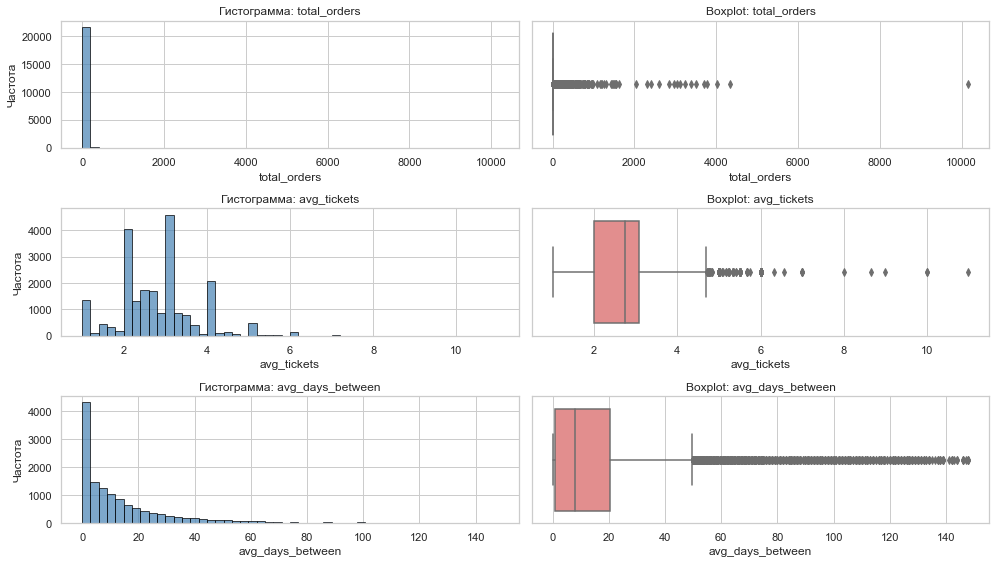

In [56]:
# Указываем стили для графиков
sns.set(style="whitegrid")

# Столбцы для анализа
numeric_cols = ['total_orders', 'avg_tickets', 'avg_days_between']

# Визуализация: гистограммы и boxplot
fig, axes = plt.subplots(3, 2, figsize=(14, 8))

for i, col in enumerate(numeric_cols):
    # Гистограмма
    axes[i, 0].hist(user_profile[col].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'Гистограмма: {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Частота')

    # Диаграмма размаха
    sns.boxplot(x=user_profile[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'Boxplot: {col}')

plt.tight_layout()

**Проанализируем полученные результаты**

1. Общее количество пользователей 21838. Достаточно для анализа профиля пользователя и прогнозирования возврата.
2. Доля пользователей, совершивших 2 и более заказа 61.70%, доля пользователей, совершивших 5 и более заказов: 28.99%. Процент пользователей, совершающих повторные покупки довольно высокий. больше половины пользователей возвращаются за повторной покупкой. Совершивших более 5 заказов тоже довольно много, почти каждый третий пользователь.
3. Есть значительый выброс в total_orders(10168). Маловероятно, что за период 152 дня(с 01.06 по 31.10) реальный пользователь мог сделать 10168 заказов. Отфильтруем по 99-перцентилю, нам нужно убрать только выбросы.
4. В столбце avg_tickets есть максимальное значени 11 билетов, но это вполне возможно, как заказ для праздников, например. Среднее и медиана практически не отличаются. Аномальных значений нет
5. В столбце avg_days_between есть большое количество дней до повторной покупки(148), это не является аномалией, если пользователь просто редко посещает мероприятия или приобретает билеты другим способом. Аномальных значений нет.

In [57]:
# --- Фильтрация по 99-му перцентилю total_orders ---
p99_orders = user_profile['total_orders'].quantile(0.99)
print(f"99-й перцентиль количества заказов: {p99_orders:.1f}")

# Применяем фильтр
user_profile_clean = user_profile[user_profile['total_orders'] <= p99_orders].copy()

# Объём отфильтрованных данных
n_original = len(user_profile)
n_clean = len(user_profile_clean)
n_removed = n_original - n_clean
perc_removed = n_removed / n_original * 100

print(f"\nОбъём данных:")
print(f"  До фильтрации: {n_original:,}")
print(f"  После фильтрации: {n_clean:,}")
print(f"  Удалено: {n_removed} пользователей ({perc_removed:.2f}%)")

# --- Статистические показатели после фильтрации ---
print("\n=== Статистика ПОСЛЕ фильтрации (total_orders ≤ 99% перцентиля) ===")
stats_clean = user_profile_clean[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)
print(stats_clean)

99-й перцентиль количества заказов: 152.0

Объём данных:
  До фильтрации: 21,838
  После фильтрации: 21,622
  Удалено: 216 пользователей (0.99%)

=== Статистика ПОСЛЕ фильтрации (total_orders ≤ 99% перцентиля) ===
       total_orders  avg_tickets  avg_days_between
count      21622.00     21622.00          13288.00
mean           6.50         2.74             16.12
std           14.31         0.92             22.42
min            1.00         1.00              0.00
25%            1.00         2.00              1.33
50%            2.00         2.75              8.38
75%            5.00         3.10             20.80
max          152.00        11.00            148.00


In [58]:
# Фильтруем по 99-му перцентилю
perc99_orders = user_profile['total_orders'].quantile(0.99)
print(f"99-й перцентиль total_orders: {perc99_orders:.2f}")

99-й перцентиль total_orders: 152.00


In [59]:
# Определяем, сколько записей будет удалено
outliers_mask = user_profile['total_orders'] > perc99_orders
sum_outliers = outliers_mask.sum()
total_rows = len(user_profile)
perc_outliers = sum_outliers / total_rows * 100

In [60]:

# Фильтрация выбросов по 99 перцентилю
user_without_outliers = user_profile[~outliers_mask].copy()

print(f"Размер датасета до фильтрации: {len(user_profile)}")
print(f"Размер датасета после фильтрации: {len(user_without_outliers )}")
print(f"Удалено строк: {len(user_profile) - len(user_without_outliers )} ({perc_outliers:.2f}%)")

Размер датасета до фильтрации: 21838
Размер датасета после фильтрации: 21622
Удалено строк: 216 (0.99%)


В результате фильтрации по 99-перцентилю из датафрейма user_profile будет удалено 216 строк(0.99%). Проверим как изменились статистические показатели

In [61]:
# Выводим статистические показатели
user_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)

,total_orders,avg_tickets,avg_days_between
count,21838.00,21838.00,13504.00
mean,13.16,2.74,15.87
std,121.56,0.91,22.33
min,1.00,1.00,0.00
25%,1.00,2.00,1.00
50%,2.00,2.75,8.00
75%,5.00,3.08,20.50
max,10168.00,11.00,148.00


In [62]:
# Выводим статистические показатели
user_without_outliers[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)

,total_orders,avg_tickets,avg_days_between
count,21622.00,21622.00,13288.00
mean,6.50,2.74,16.12
std,14.31,0.92,22.42
min,1.00,1.00,0.00
25%,1.00,2.00,1.33
50%,2.00,2.75,8.38
75%,5.00,3.10,20.80
max,152.00,11.00,148.00


Стандартное отклонение в total_orders значительно уменьшилось(со 121.56 до 14.31), при этом 25й, 50й и 75й перцентили не изменились. можо считать, что данные стали репрезентативнее. Статистические показатели в столбцах avg_tickets, avg_days_between почти не изменились. Результат фильтрования выбросов устраивает.

In [63]:
# Заменим данные в user_prifile с учетом удаления выбросов
user_profile = user_without_outliers

In [64]:
# Выводим на экран user_profile
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21622 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           21622 non-null  object        
 1   first_order_date  21622 non-null  datetime64[ns]
 2   last_order_date   21622 non-null  datetime64[ns]
 3   device_first      21622 non-null  object        
 4   region_first      21622 non-null  object        
 5   service_first     21622 non-null  object        
 6   event_type_first  21622 non-null  object        
 7   total_orders      21622 non-null  int64         
 8   avg_revenue_rub   21622 non-null  float32       
 9   avg_tickets       21622 non-null  float64       
 10  avg_days_between  13288 non-null  float64       
 11  is_two            21622 non-null  int32         
 12  is_five           21622 non-null  int32         
dtypes: datetime64[ns](2), float32(1), float64(2), int32(2), int64(1), object(5)


**Промежуточный вывод**

1. Доля пользователей, совершивших 2 и более заказа 61.70%, доля пользователей, совершивших 5 и более заказов: 28.99%. Процент пользователей, совершающих повторные покупки довольно высокий. больше половины пользователей возвращаются за повторной покупкой. Совершивших более 5 заказов тоже довольно много, почти каждый третий пользователь.
2. Отфильтровали total_orders по 99-перцентилю.В результате было удалено 216 строк (0.99%)
3. В столбце avg_tickets есть максимальное значени 11 билетов, но это вполне возможно, как заказ для праздников, например. Среднее и медиана практически не отличаются. Аномальных значений нет
4. В столбце avg_days_between есть большое количество дней до повторной покупки(148), это не является аномалией, если пользователь просто редко посещает мероприятия или приобретает билеты другим способом. Аномальных значений нет.
5. Итоговый размер датасета user_profile, содержащего данные о профиле пользователя 21622 строк и 13 столбцов

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


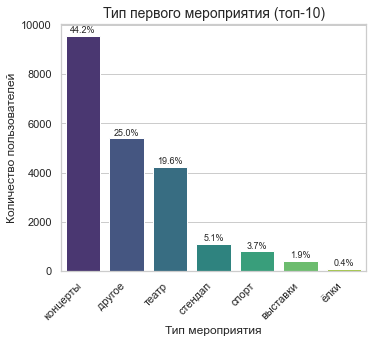

In [65]:
# Настройки для визуализации
sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))

# Общее количество пользователей
total = len(user_profile)

# Распределение по типу первого мероприятия

plt.subplot(2, 2, 1)
event_counts = user_profile['event_type_first'].value_counts().head(10)
event_df = pd.DataFrame({
    'event_type': event_counts.index,
    'count': event_counts.values
})
sns.barplot(data=event_df, x='event_type', y='count', palette='viridis')
plt.title('Тип первого мероприятия (топ-10)', fontsize=14)
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')

# Добавляем процентные доли
for i, v in enumerate(event_counts):
    percentage = (v / total) * 100
    plt.text(i, v + total*0.005, f'{percentage:.1f}%', ha='center', fontsize=9)

In [66]:
# Выводим топ-5 типов первого мероприятия
print("ТИП ПЕРВОГО МЕРОПРИЯТИЯ (топ-5):")
top_5_events = user_profile['event_type_first'].value_counts().head(5)
for event, count in top_5_events.items():
    share = (count / total) * 100
    print(f"   • {event}: {count:,} пользователей ({share:.1f}%)")

print(f"\n   На топ-5 типов мероприятий приходится {top_5_events.sum()/total*100:.1f}% всех пользователей")

ТИП ПЕРВОГО МЕРОПРИЯТИЯ (топ-5):
   • концерты: 9,564 пользователей (44.2%)
   • другое: 5,401 пользователей (25.0%)
   • театр: 4,245 пользователей (19.6%)
   • стендап: 1,110 пользователей (5.1%)
   • спорт: 794 пользователей (3.7%)

   На топ-5 типов мероприятий приходится 97.7% всех пользователей


Первым мероприятияем для наибольшего количества пользователей является концерт: 9564 пользователя(44.2%)

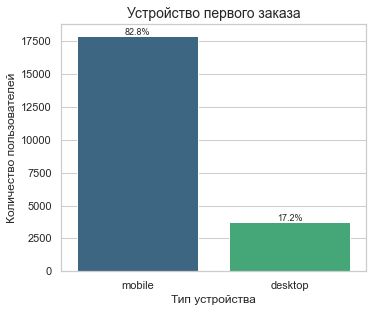

In [67]:
# Настройки для визуализации
sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))

# Распределение по типу устройства
plt.subplot(2, 2, 2)
device_counts = user_profile['device_first'].value_counts()
device_df = pd.DataFrame({
    'device_type': device_counts.index,
    'count': device_counts.values
})
sns.barplot(data=device_df, x='device_type', y='count', palette='viridis')
plt.title('Устройство первого заказа', fontsize=14)
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')

for i, v in enumerate(device_counts):
    percentage = (v / total) * 100
    plt.text(i, v + total*0.005, f'{percentage:.1f}%', ha='center', fontsize=9)

In [68]:
# Выводим распределение пользователе по типу устройства
print("ТИП УСТРОЙСТВА ПЕРВОГО ЗАКАЗА:")
for device, count in device_counts.items():
    share = (count / total) * 100
    print(f"   • {device}: {count:,} пользователей ({share:.1f}%)")

ТИП УСТРОЙСТВА ПЕРВОГО ЗАКАЗА:
   • mobile: 17,906 пользователей (82.8%)
   • desktop: 3,716 пользователей (17.2%)


Плодавляющее большинство пользователей (17906, 82.8%) делают 1й заказ с мобильных устройств.

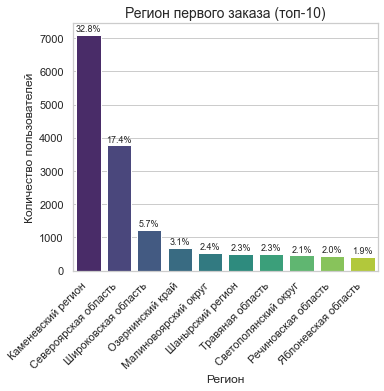

In [69]:
# Настройки для визуализации
sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))

# Распределение по региону
plt.subplot(2, 2, 3)
region_counts = user_profile['region_first'].value_counts().head(10)
region_df = pd.DataFrame({
    'region': region_counts.index,
    'count': region_counts.values
})
sns.barplot(data=region_df, x='region', y='count', palette='viridis')
plt.title('Регион первого заказа (топ-10)', fontsize=14)
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(region_counts):
    percentage = (v / total) * 100
    plt.text(i, v + total*0.005, f'{percentage:.1f}%', ha='center', fontsize=9)

In [70]:
# Выводим топ-5 по региону
print("РЕГИОН ПЕРВОГО ЗАКАЗА (топ-5):")
top_5_regions = user_profile['region_first'].value_counts().head(5)
for region, count in top_5_regions.items():
    share = (count / total) * 100
    print(f"   • {region}: {count:,} пользователей ({share:.1f}%)")

РЕГИОН ПЕРВОГО ЗАКАЗА (топ-5):
   • Каменевский регион: 7,086 пользователей (32.8%)
   • Североярская область: 3,768 пользователей (17.4%)
   • Широковская область: 1,223 пользователей (5.7%)
   • Озернинский край: 675 пользователей (3.1%)
   • Малиновоярский округ: 526 пользователей (2.4%)


Больше всего пользователей делали свой первый заказ в Каменевском регионе (7086 пользователей, 32.8%), на втором месте Североярская область (3768 пользователей, 17.4%). В остальным регионах доля пользователей, оформивших свой первый заказ значительно ниже.

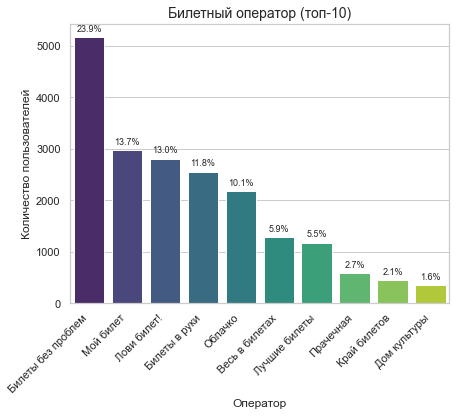

In [71]:
# Настройки для визуализации
sns.set_style("whitegrid")
plt.figure(figsize=(12, 10))

# Распределение по билетному оператору
plt.subplot(2, 2, 4)
service_counts = user_profile['service_first'].value_counts().head(10)
service_df = pd.DataFrame({
    'service': service_counts.index,
    'count': service_counts.values
})
sns.barplot(data=service_df, x='service', y='count', palette='viridis')
plt.title('Билетный оператор (топ-10)', fontsize=14)
plt.xlabel('Оператор')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(service_counts):
    percentage = (v / total) * 100
    plt.text(i, v + total*0.005, f'{percentage:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [72]:
# Выводим топ-5 билетных операторов
print("БИЛЕТНЫЙ ОПЕРАТОР (топ-5):")
top_5_services = user_profile['service_first'].value_counts().head(5)
for service, count in top_5_services.items():
    share = (count / total) * 100
    print(f"   • {service}: {count:,} пользователей ({share:.1f}%)")

БИЛЕТНЫЙ ОПЕРАТОР (топ-5):
   • Билеты без проблем: 5,167 пользователей (23.9%)
   • Мой билет: 2,970 пользователей (13.7%)
   • Лови билет!: 2,812 пользователей (13.0%)
   • Билеты в руки: 2,557 пользователей (11.8%)
   • Облачко: 2,177 пользователей (10.1%)


На долю билетного оператора "Билеты без проблем" приходится самое большое количество пользователей: 5,167 пользователей (23.9%).

Пользователи по всем сегментам распределены неравномерно, есть выраженные "точки входа"

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [73]:
# Общая доля возврата
overall_return = user_profile['is_two'].mean() * 100
print(f"Общая доля пользователей с 2+ заказами: {overall_return:.1f}%")

Общая доля пользователей с 2+ заказами: 61.3%


**Анализ по типу мероприятия**

In [74]:
# Группируем по типу мероприятия
event_stats = user_profile.groupby('event_type_first').agg(
    total_users=('user_id', 'count'),
    return_users=('is_two', 'sum')
).reset_index()

# Рассчитываем долю возврата
event_stats['return_rate'] = round((event_stats['return_users'] / event_stats['total_users']) * 100, 2)

# Сортируем по количеству пользователей
event_stats = event_stats.sort_values('total_users', ascending=False)


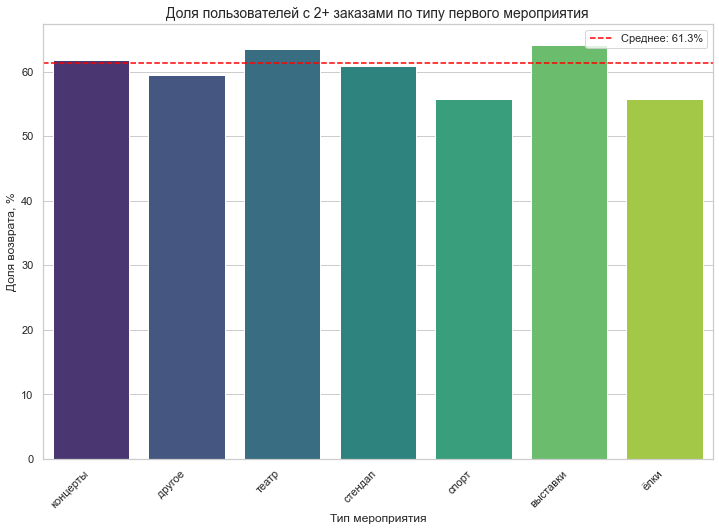

In [75]:
# Визуализация
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=event_stats, x='event_type_first', y='return_rate', palette='viridis')

# Линия среднего
plt.axhline(y=overall_return, color='red', linestyle='--', 
            label=f'Среднее: {overall_return:.1f}%')

plt.title('Доля пользователей с 2+ заказами по типу первого мероприятия', fontsize=14)
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля возврата, %')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')


In [76]:
# Вывод результатов
print("Мероприятия и количество пользователе, вернувшихся за повторным заказом ")
print(event_stats.to_string(index=False))

Мероприятия и количество пользователе, вернувшихся за повторным заказом 
event_type_first  total_users  return_users  return_rate
        концерты         9564          5912        61.82
          другое         5401          3217        59.56
           театр         4245          2693        63.44
         стендап         1110           676        60.90
           спорт          794           443        55.79
        выставки          413           265        64.16
            ёлки           95            53        55.79


Доля возвращающихся за повторным заказом пользователей выше всего у мероприятий: выставки(64.16%) и театр(63.44%) 

**Анализ по типу устройства**

In [77]:
# Группируем по типу устройства
device_stats = user_profile.groupby('device_first').agg(
    total_users=('user_id', 'count'),
    return_users=('is_two', 'sum')
).reset_index()

# Рассчитываем долю возврата
device_stats['return_rate'] = round((device_stats['return_users'] / device_stats['total_users']) * 100, 2)

# Сортируем по количеству пользователей
device_stats = device_stats.sort_values('total_users', ascending=False)


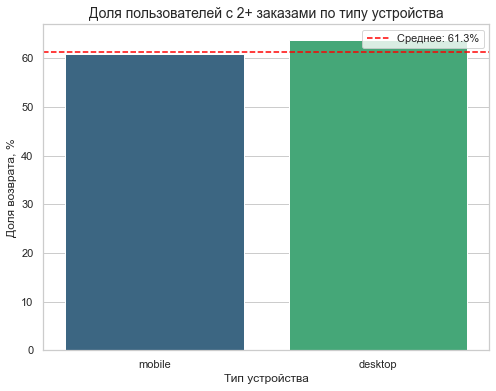

In [78]:
# Визуализация
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=device_stats, x='device_first', y='return_rate', palette='viridis')

# Линия среднего
plt.axhline(y=overall_return, color='red', linestyle='--', 
            label=f'Среднее: {overall_return:.1f}%')

plt.title('Доля пользователей с 2+ заказами по типу устройства', fontsize=14)
plt.xlabel('Тип устройства')
plt.ylabel('Доля возврата, %')
plt.legend(loc='upper right')

In [79]:
# Вывод результатов
print("Доля возврата по типу устройства:")
print(device_stats.to_string(index=False))

Доля возврата по типу устройства:
device_first  total_users  return_users  return_rate
      mobile        17906         10887        60.80
     desktop         3716          2372        63.83


Пользователи, оформившие первый заказ с десктопа, возвращаются за повторным заказом чаще. Но по обоим типам устроств доля вернувшихся пользователей довольно высокая и различается не сильно(разница чуть меньше 5%).

**Анализ по региону**

In [80]:
# Группируем по региону
region_stats = user_profile.groupby('region_first').agg(
    total_users=('user_id', 'count'),
    return_users=('is_two', 'sum')
).reset_index()

# Рассчитываем долю возврата
region_stats['return_rate'] = round((region_stats['return_users'] / region_stats['total_users']) * 100, 2)

# Сортируем по количеству пользователей и берем топ-10
region_stats = region_stats.sort_values('total_users', ascending=False).head(10)



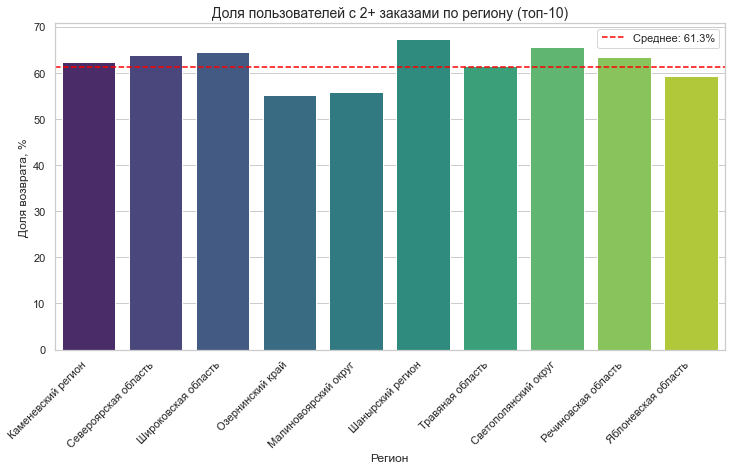

In [81]:
# Визуализация
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=region_stats, x='region_first', y='return_rate', palette='viridis')

# Линия среднего
plt.axhline(y=overall_return, color='red', linestyle='--', 
            label=f'Среднее: {overall_return:.1f}%')

plt.title('Доля пользователей с 2+ заказами по региону (топ-10)', fontsize=14)
plt.xlabel('Регион')
plt.ylabel('Доля возврата, %')
plt.xticks(rotation=45, ha='right')
plt.legend()

In [82]:
# Вывод результатов
print("Топ-10 регионов по возврату пользователей:")
print(region_stats.to_string(index=False))

Топ-10 регионов по возврату пользователей:
        region_first  total_users  return_users  return_rate
  Каменевский регион         7086          4421        62.39
Североярская область         3768          2405        63.83
 Широковская область         1223           788        64.43
    Озернинский край          675           373        55.26
Малиновоярский округ          526           294        55.89
    Шанырский регион          502           338        67.33
    Травяная область          488           300        61.48
Светополянский округ          457           300        65.65
 Речиновская область          440           279        63.41
 Яблоневская область          411           244        59.37


Самая большая доля повторно обращающихся пользователей в Шанырском регионе(67.33%), Светополянском округе(65.65%), Широковской области(64.43%).

**Анализ по билетному оператору**

In [83]:
# Группируем по билетному оператору
service_stats = user_profile.groupby('service_first').agg(
    total_users=('user_id', 'count'),
    return_users=('is_two', 'sum')
).reset_index()

# Рассчитываем долю возврата
service_stats['return_rate'] = round((service_stats['return_users'] / service_stats['total_users']) * 100, 2)

# Сортируем по количеству пользователей и берем топ-10
service_stats = service_stats.sort_values('total_users', ascending=False).head(10)



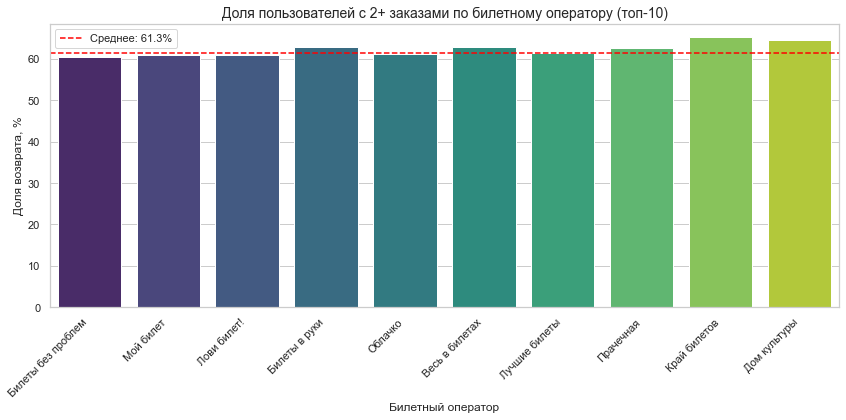

In [84]:
# Визуализация
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=service_stats, x='service_first', y='return_rate', palette='viridis')

# Линия среднего
plt.axhline(y=overall_return, color='red', linestyle='--', 
            label=f'Среднее: {overall_return:.1f}%')

plt.title('Доля пользователей с 2+ заказами по билетному оператору (топ-10)', fontsize=14)
plt.xlabel('Билетный оператор')
plt.ylabel('Доля возврата, %')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()


In [85]:
# Вывод результатов
print("Топ-10 билетных операторов по возврату пользователей:")
print(service_stats.to_string(index=False))

Топ-10 билетных операторов по возврату пользователей:
     service_first  total_users  return_users  return_rate
Билеты без проблем         5167          3117        60.33
         Мой билет         2970          1808        60.88
       Лови билет!         2812          1714        60.95
     Билеты в руки         2557          1605        62.77
           Облачко         2177          1333        61.23
    Весь в билетах         1286           809        62.91
     Лучшие билеты         1182           725        61.34
         Прачечная          583           365        62.61
      Край билетов          454           296        65.20
      Дом культуры          356           230        64.61


Пользователи билетных операторов "Край билетов" и "Дом культуры" наиболее лояльны.

Наблюдаются успешные "точки входа":

- Жанры: театр, выставки, концерты;
- Устройства: desktop;
- Регионы: Шанырский, Светополянский;
- Билетные операторы: Край билетов, Дом культуры.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1:**
Тип мероприятия влияет на вероятность возврата

По данным из анализа 4.1.2 среди топ-10 типов мероприятий:
- спорт: доля повторно обратившихся пользователей 55.8% (-5.5% к среднему)
- концерты: доля повторно обратившихся пользователей  61.8% (+0.5% к среднему)

Вывод по гипотезе 1:
Гипотеза не подтверждается. Концерты имеют возврат на 6.0% выше, чем спортивные мероприятия

**Гипотеза 2:**
В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

По данным из анализа 4.1.2 среди топ-10 регионов:
- Больше всего пользователей посещают мероприятия в регионах:
    - Каменевский регион 7086 пользователей, доля вернувшихся 62.39%
    - Североярская область 3768 пользователей, доля вернувшихся 63.83%%
    
    
- Самая большая доля повторно обращающихся пользователей:
    - Шанырский регион(67.33%)
    - Светополянский округ(65.65%)

Вывод по гипотезе 2:
Гипотеза не подтверждается. Топ-регионы по количеству посещающих мероприятия не сопажают с топ-регионами по доле повторно обратившихся пользователей.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [86]:
# Разделяем пользователей на две группы
single_order_users = user_profile[user_profile['total_orders'] == 1]
returned_users = user_profile[user_profile['total_orders'] >= 2]

print(f"Пользователей с одним заказом: {len(single_order_users):,}")
print(f"Пользователей с 2+ заказами: {len(returned_users):,}")
print(f"Общее количество пользователей: {len(user_profile):,}\n")

print(f"Средняя выручка с заказа:")
print(f"• Один заказ: {single_order_users['avg_revenue_rub'].mean():.1f} ₽")
print(f"• 2+ заказа: {returned_users['avg_revenue_rub'].mean():.1f} ₽")
print(f"• Общая: {user_profile['avg_revenue_rub'].mean():.1f} ₽")

Пользователей с одним заказом: 8,363
Пользователей с 2+ заказами: 13,259
Общее количество пользователей: 21,622

Средняя выручка с заказа:
• Один заказ: 545.8 ₽
• 2+ заказа: 545.1 ₽
• Общая: 545.3 ₽


In [87]:
# Статистика средней выручки у пользователей с одним заказом
single_order_users['avg_revenue_rub'].describe()

count    8363.000000
mean      545.773499
std       519.402161
min         0.000000
25%       133.055000
50%       378.869995
75%       830.975006
max      2628.421631
Name: avg_revenue_rub, dtype: float64

In [88]:
# Статистика средней выручки у пользователей с 2 и более заказами
returned_users['avg_revenue_rub'].describe()

count    13259.000000
mean       545.062500
std        369.249481
min          0.000000
25%        271.682495
50%        496.543335
75%        745.630554
max       2628.421631
Name: avg_revenue_rub, dtype: float64

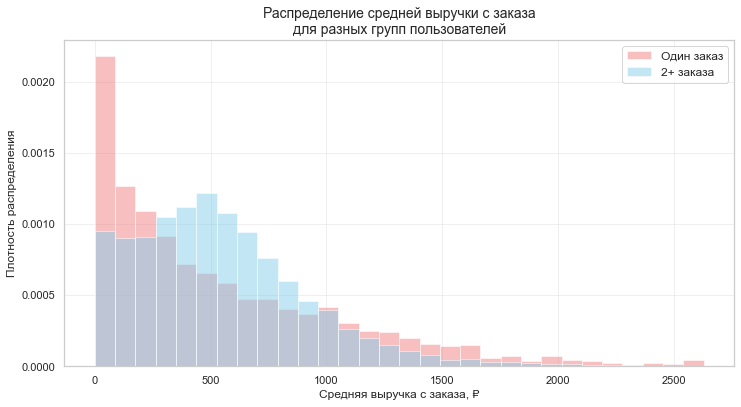

In [89]:
# Построение сравнительных гистограмм
plt.figure(figsize=(12, 6))

# Определяем границы для одинаковых интервалов
min_revenue = user_profile['avg_revenue_rub'].min()
max_revenue = user_profile['avg_revenue_rub'].max()
bins = 30

# Гистограмма для пользователей с одним заказом
plt.hist(single_order_users['avg_revenue_rub'], 
         bins=bins, alpha=0.5, color='lightcoral', 
         density=True, label='Один заказ')

# Гистограмма для вернувшихся пользователей
plt.hist(returned_users['avg_revenue_rub'], 
         bins=bins, alpha=0.5, color='skyblue', 
         density=True, label='2+ заказа')

plt.title('Распределение средней выручки с заказа\nдля разных групп пользователей', fontsize=14)
plt.xlabel('Средняя выручка с заказа, ₽', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)


1. В каких диапазонах средней выручки концентрируются пользователи?

   Пользователи с одним заказом:
   - 50% пользователей в диапазоне: 133.1 - 831.0 ₽
   - Медиана: 378.9 ₽

   Пользователи с 2+ заказами:
   - 50% пользователей в диапазоне: 271.7 - 745.6 ₽
   - Медиана: 496.5 ₽


2. Есть ли различия между группами?

   Сравнение средних значений:
   - Разница средних: -0.7 ₽
   - Разница медиан: 117.7 ₽
   - Вернувшиеся пользователи тратят в среднем на 0.7 ₽ меньше

   Сравнение формы распределения:
   - Оба распределения похожи по форме
   - Основная концентрация в диапазоне 300-800 ₽
   - У вернувшихся пользователей распределение немного смещено вправо

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [90]:
# Создаем группы пользователей
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

print(f"Пользователей с 2-4 заказами: {len(group_2_4):}")
print(f"Пользователей с 5+ заказами: {len(group_5_plus):}")
print(f"Всего пользователей с повторными заказами: {len(group_2_4) + len(group_5_plus):}\n")

Пользователей с 2-4 заказами: 7145
Пользователей с 5+ заказами: 6114
Всего пользователей с повторными заказами: 13259



In [91]:
# Статистика средней выручки у пользователей совершивших 2–4 заказа
group_2_4['avg_revenue_rub'].describe()

count    7145.000000
mean      552.257812
std       420.128204
min         0.000000
25%       219.500000
50%       472.470001
75%       798.830017
max      2628.421631
Name: avg_revenue_rub, dtype: float64

In [92]:
# Статистика средней выручки у пользователей совершивших 5+ заказов
group_5_plus['avg_revenue_rub'].describe()

count    6114.000000
mean      536.656128
std       298.832520
min         0.000000
25%       331.749359
50%       513.308990
75%       701.096237
max      2299.868896
Name: avg_revenue_rub, dtype: float64

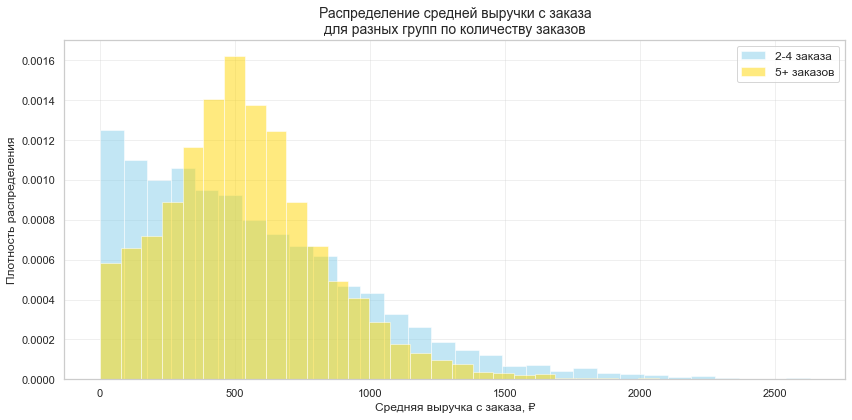

In [93]:
# Построение сравнительных гистограмм
plt.figure(figsize=(12, 6))

# Определяем общие границы для одинаковых интервалов
all_revenue = pd.concat([group_2_4['avg_revenue_rub'], group_5_plus['avg_revenue_rub']])
bins = 30  # Количество интервалов

# Гистограмма для группы 2-4 заказа
plt.hist(group_2_4['avg_revenue_rub'], 
         bins=bins, alpha=0.5, color='skyblue', 
         density=True, label='2-4 заказа')

# Гистограмма для группы 5+ заказов
plt.hist(group_5_plus['avg_revenue_rub'], 
         bins=bins, alpha=0.5, color='gold', 
         density=True, label='5+ заказов')

plt.title('Распределение средней выручки с заказа\nдля разных групп по количеству заказов', fontsize=14)
plt.xlabel('Средняя выручка с заказа, ₽', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()

Есть ли различия по значению средней выручки с заказа между группами?

1. Сравнение средних значений:
   - Группа 2-4 заказа: 552.3 ₽
   - Группа 5+ заказов: 536.7 ₽
   - Разница: -15.6 ₽
   
   
   Пользователи с 5+ заказами тратят в среднем на 15.6 ₽ меньше

2. Сравнение медиан:
   - Группа 2-4 заказа: 472.5 ₽
   - Группа 5+ заказов: 513.3 ₽
   - Разница: 40.8 ₽

3. Анализ диапазонов концентрации:
   - 2-4 заказа: 50% пользователей в диапазоне 219.5 - 798.8 ₽
   - 5+ заказов: 50% пользователей в диапазоне 331.7 - 701.1 ₽

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [94]:
# Изучаем распределение среднего количества билетов
user_profile['avg_tickets'].describe()

count    21622.000000
mean         2.744257
std          0.917477
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets, dtype: float64

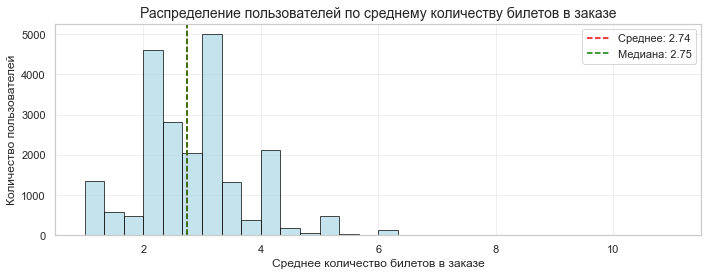

In [95]:
# Гистограмма распределения среднего количества билетов
plt.figure(figsize=(10, 4))

# Создаем гистограмму
plt.hist(user_profile['avg_tickets'], bins=30, color='lightblue', 
         edgecolor='black', alpha=0.7)

plt.title('Распределение пользователей по среднему количеству билетов в заказе', fontsize=14)
plt.xlabel('Среднее количество билетов в заказе', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(True, alpha=0.3)

# Добавляем линии среднего и медианы
plt.axvline(x=user_profile['avg_tickets'].mean(), color='red', 
            linestyle='--', label=f'Среднее: {user_profile["avg_tickets"].mean():.2f}')
plt.axvline(x=user_profile['avg_tickets'].median(), color='green', 
            linestyle='--', label=f'Медиана: {user_profile["avg_tickets"].median():.2f}')
plt.legend()

plt.tight_layout()

По итогу изучения распределение пользователей по среднему количеству билетов в заказе:
- Среднее число билетов в заказе: 2.74
- Медиана: 2.75. Большинство пользователей покупают в среднем 2–3 билета
- 75% пользователей покупают <= 3.1 билетов
- Максимальное значение: 11.0.  Есть пользователи с высоким средним количеством билетов(покупают для группы людей)

In [96]:
# Определяем сегменты по количеству билетов
segments = [
    (1, 2, 'от 1 до 2 билетов'),
    (2, 3, 'от 2 до 3 билетов'),
    (3, 5, 'от 3 до 5 билетов'),
    (5, float('inf'), 'от 5 и более билетов')
]

In [97]:
# Создаем DataFrame для хранения результатов
segment_stats = []

for min_tickets, max_tickets, segment_name in segments:
    if max_tickets == float('inf'):
        mask = (user_profile['avg_tickets'] >= min_tickets)
    else:
        mask = (user_profile['avg_tickets'] >= min_tickets) & (user_profile['avg_tickets'] < max_tickets)
    
    segment_users = user_profile[mask]
    
    total_users = len(segment_users)
    return_users = segment_users['is_two'].sum()
    return_rate = (return_users / total_users * 100) if total_users > 0 else 0
    
    segment_stats.append({
        'Сегмент': segment_name,
        'Диапазон билетов': f"{min_tickets}-{max_tickets if max_tickets != float('inf') else '∞'}",
        'Количество пользователей': total_users,
        'Доля от общего числа': (total_users / len(user_profile) * 100),
        'Возврат (2+ заказа)': return_rate
    })

segment_df = pd.DataFrame(segment_stats)

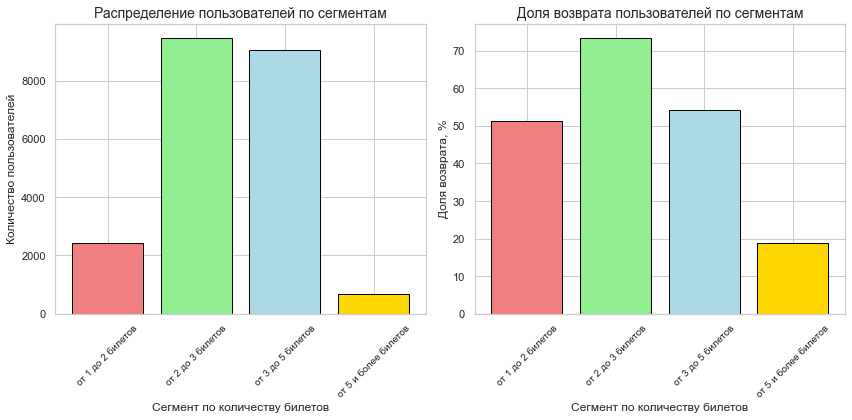

In [98]:
# Визуализация сегментов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold']

# График 1: Распределение пользователей по сегментам
ax1.bar(segment_df['Сегмент'], segment_df['Количество пользователей'], 
        color=colors, edgecolor='black')
ax1.set_title('Распределение пользователей по сегментам', fontsize=14)
ax1.set_xlabel('Сегмент по количеству билетов')
ax1.set_ylabel('Количество пользователей')
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# График 2: Доля возврата по сегментам
bars = ax2.bar(segment_df['Сегмент'], segment_df['Возврат (2+ заказа)'], 
               color=colors, edgecolor='black')
ax2.set_title('Доля возврата пользователей по сегментам', fontsize=14)
ax2.set_xlabel('Сегмент по количеству билетов')
ax2.set_ylabel('Доля возврата, %')
ax2.tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()

In [99]:
# Выводим результаты
print(segment_df.to_string(index=False))

             Сегмент Диапазон билетов  Количество пользователей  Доля от общего числа  Возврат (2+ заказа)
   от 1 до 2 билетов              1-2                      2410             11.146055            51.244813
   от 2 до 3 билетов              2-3                      9486             43.871982            73.561037
   от 3 до 5 билетов              3-5                      9065             41.924891            54.296746
от 5 и более билетов              5-∞                       661              3.057072            18.759455


1. Как распределены пользователи по сегментам — равномерно или сконцентрировано?


- Самый крупный сегмент: от 2 до 3 билетов
- Доля этого сегмента: 43.9% всех пользователей


Распределение умеренно концентрированное. Есть явно выраженный основной сегмент


Распределение по сегментам:
  - от 1 до 2 билетов: 11.1%
  - от 2 до 3 билетов: 43.9%
  - от 3 до 5 билетов: 41.9%
  - от 5 и более билетов: 3.1%


2. Есть ли сегменты с аномально высокой или низкой долей повторных покупок?


- Общая доля возврата: 61.3%

- Анализ отклонений от среднего:


Сегменты с аномально высокой долей возврата:
    - от 2 до 3 билетов: 73.6% (+12.2% к среднему)


Сегменты с аомально низкой долей возврата:
    - от 1 до 2 билетов: 51.2% (-10.1% к среднему)
    - от 3 до 5 билетов: 54.3% (-7.0% к среднему)
    - от 5 и более билетов: 18.8% (-42.6% к среднему)

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [100]:
# Извлекаем день недели из даты первого заказа
user_profile['first_order_weekday'] = user_profile['first_order_date'].dt.day_name()

In [101]:
# Определяем порядок дней недели для корректной сортировки
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [102]:
# Создаем категориальный тип для сортировки
user_profile['first_order_weekday'] = pd.Categorical(
    user_profile['first_order_weekday'], 
    categories=weekday_order, 
    ordered=True
)

In [103]:
# Группируем по дням недели
weekday_stats = user_profile.groupby('first_order_weekday').agg(
    total_users=('user_id', 'count'),
    return_users=('is_two', 'sum')
).reset_index()

In [104]:
# Рассчитываем долю возврата
weekday_stats['return_rate'] = round((weekday_stats['return_users'] / weekday_stats['total_users']) * 100, 2)

In [105]:
# Рассчитываем долю от общего числа пользователей
total_users_all = weekday_stats['total_users'].sum()
weekday_stats['share_of_total'] = (weekday_stats['total_users'] / total_users_all) * 100

print(f"Всего пользователей: {total_users_all:,}")
print(f"Общая доля возврата: {user_profile['is_two'].mean()*100:.1f}%\n")

Всего пользователей: 21,622
Общая доля возврата: 61.3%



In [106]:
# Сортируем по убыванию возврата
weekday_sorted = weekday_stats.sort_values('return_rate', ascending=False)
overall_return_weekday = user_profile['is_two'].mean() * 100

print(f"Рейтинг дней недели по возврату пользователей:")

for i, row in weekday_sorted.iterrows():
    rank = i + 1
    diff = row['return_rate'] - overall_return_weekday
    sign = '+' if diff > 0 else ''
    print(f"{row['first_order_weekday']}:")
    print(f"   - Возврат: {row['return_rate']:.1f}% ({sign}{diff:.1f}%)")
    print(f"   - Пользователей: {row['total_users']:,} ({row['share_of_total']:.1f}% от общего числа)")
    print()

Рейтинг дней недели по возврату пользователей:
Monday:
   - Возврат: 63.0% (+1.7%)
   - Пользователей: 2,918 (13.5% от общего числа)

Saturday:
   - Возврат: 62.8% (+1.4%)
   - Пользователей: 3,323 (15.4% от общего числа)

Wednesday:
   - Возврат: 62.3% (+0.9%)
   - Пользователей: 3,061 (14.2% от общего числа)

Tuesday:
   - Возврат: 61.9% (+0.6%)
   - Пользователей: 3,175 (14.7% от общего числа)

Sunday:
   - Возврат: 60.1% (-1.3%)
   - Пользователей: 2,777 (12.8% от общего числа)

Friday:
   - Возврат: 59.8% (-1.6%)
   - Пользователей: 3,256 (15.1% от общего числа)

Thursday:
   - Возврат: 59.5% (-1.9%)
   - Пользователей: 3,112 (14.4% от общего числа)



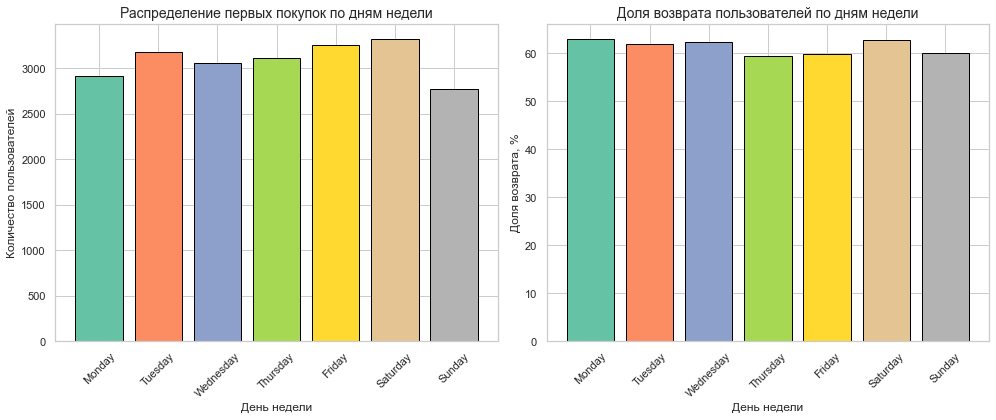

In [107]:
# Создаем график с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.Set2(np.linspace(0, 1, 7))

# График 1: Распределение пользователей по дням недели
bars1 = ax1.bar(weekday_stats['first_order_weekday'], weekday_stats['total_users'], 
                color=colors, edgecolor='black')
ax1.set_title('Распределение первых покупок по дням недели', fontsize=14)
ax1.set_xlabel('День недели')
ax1.set_ylabel('Количество пользователей')
ax1.tick_params(axis='x', rotation=45)

# График 2: Доля возврата по дням недели
bars2 = ax2.bar(weekday_stats['first_order_weekday'], weekday_stats['return_rate'], 
                color=colors, edgecolor='black')
ax2.set_title('Доля возврата пользователей по дням недели', fontsize=14)
ax2.set_xlabel('День недели')
ax2.set_ylabel('Доля возврата, %')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()

**Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?**


Анализ различий:
   - Максимальный возврат: 63.0% (Monday)
   - Минимальный возврат: 59.5% (Thursday)
   - Размах: 3.5 процентных пунктов
   
   
Вывод:


Различия небольшие. День недели не оказывает значительного влияния на возврат

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [108]:
# Оставляем только пользователей с данными об интервалах
group_2_4_clean = group_2_4[group_2_4['avg_days_between'].notna()]
group_5_plus_clean = group_5_plus[group_5_plus['avg_days_between'].notna()]

In [109]:
# Статистика средних интервалов между заказами для пользователей с 2-4 покупками
group_2_4_clean['avg_days_between'].describe()

count    7145.000000
mean       21.343772
std        28.512209
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between, dtype: float64

In [110]:
# Статистика средних интервалов между заказами для пользователей с 5+ покупками
group_5_plus['avg_days_between'].describe()

count    6114.000000
mean        9.907050
std         7.806557
min         0.000000
25%         3.885714
50%         8.129167
75%        14.108333
max        37.500000
Name: avg_days_between, dtype: float64

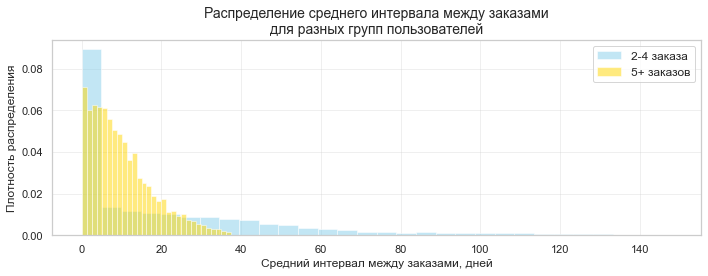

In [111]:
# Гистограммы распределений
plt.figure(figsize=(10, 4))

# Определяем общие границы для одинаковых интервалов
all_intervals = pd.concat([group_2_4_clean['avg_days_between'], group_5_plus_clean['avg_days_between']])
bins = 30

# Гистограмма для группы 2-4 заказа
plt.hist(group_2_4_clean['avg_days_between'], 
         bins=bins, alpha=0.5, color='skyblue', 
         density=True, label='2-4 заказа')

# Гистограмма для группы 5+ заказов
plt.hist(group_5_plus_clean['avg_days_between'], 
         bins=bins, alpha=0.5, color='gold', 
         density=True, label='5+ заказов')

plt.title('Распределение среднего интервала между заказами\nдля разных групп пользователей', fontsize=14)
plt.xlabel('Средний интервал между заказами, дней', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()

Пользователи с 5+ билетами, совершают покупки чаще, в промежутке до 40 дней. Пользователи же с 2-4  билетами совершают покупки как правило в течение первых 5 дней. Также эта категория пользователей иногда приобретает билеты через длительный промежуток времени(до нескольких месяцев), чего не наблюдается для категории 5+(максимальное значение 37.5 дней).

Разобьем на сегменты по интервалам и построим столбчатую диаграмму дял сравнения

In [112]:
# Создаем общую группу пользователей с повторными заказами и данными об интервалах
returning_users = pd.concat([group_2_4_clean, group_5_plus_clean])


In [113]:
# Определяем сегменты по интервалам
interval_bins = [0, 7, 14, 30, 60, float('inf')]
interval_labels = ['<1 недели', '1-2 недели', '2-4 недели', '1-2 месяца', '>2 месяцев']

In [114]:
# Добавляем категорию интервала
returning_users['interval_category'] = pd.cut(
    returning_users['avg_days_between'], 
    bins=interval_bins, 
    labels=interval_labels,
    right=False
)

In [115]:
# Группируем по интервалам
interval_stats = returning_users.groupby('interval_category').agg(
    total_users=('user_id', 'count'),
    group_2_4=('total_orders', lambda x: ((x >= 2) & (x <= 4)).sum()),
    group_5_plus=('total_orders', lambda x: (x >= 5).sum())
).reset_index()

In [116]:
# Рассчитываем доли
interval_stats['share_of_total'] = (interval_stats['total_users'] / len(returning_users)) * 100
interval_stats['share_2_4'] = (interval_stats['group_2_4'] / interval_stats['total_users']) * 100
interval_stats['share_5_plus'] = (interval_stats['group_5_plus'] / interval_stats['total_users']) * 100

print("\nРаспределение пользователей по интервалам между заказами:")
print(interval_stats[['interval_category', 'total_users', 'share_of_total']].to_string(index=False))


Распределение пользователей по интервалам между заказами:
interval_category  total_users  share_of_total
        <1 недели         6003       45.274908
       1-2 недели         2493       18.802323
       2-4 недели         2578       19.443397
       1-2 месяца         1471       11.094351
       >2 месяцев          714        5.385021


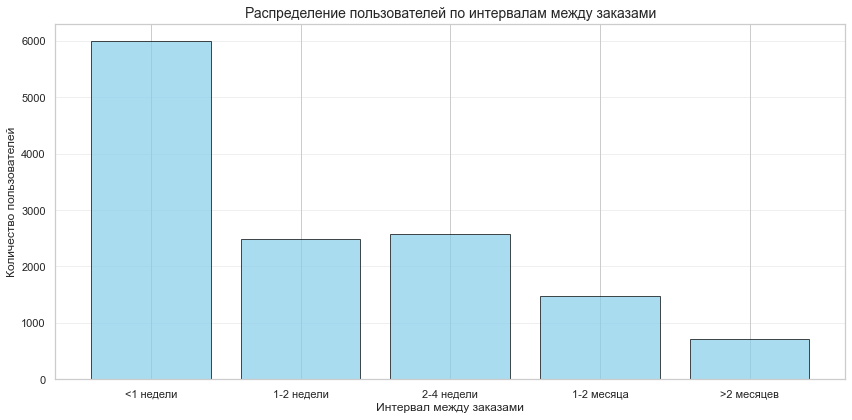

In [117]:
# Столбчатая диаграмма распределения по интервалам
plt.figure(figsize=(12, 6))

bars = plt.bar(interval_stats['interval_category'], interval_stats['total_users'], 
               color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Распределение пользователей по интервалам между заказами', fontsize=14)
plt.xlabel('Интервал между заказами', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

Анализ распределения:

1. Самый частый интервал: <1 недели
   - Пользователей: 6,003 (45.3%)
   - Из них 2-4 заказа: 55.5%
   - Из них 5+ заказов: 44.5%
   

2. Где больше всего активных пользователей (5+ заказов):
   - Интервал: 1-2 недели
   - Доля активных: 75.6%
   - Всего пользователей: 2,493
   

3. Где меньше всего активных пользователей:
   - Интервал: >2 месяцев
   - Доля активных: 0.0%
   - Всего пользователей: 714
   - Разница: 75.6 процентных пунктов

**Как средний интервал между заказами влияет на удержание клиентов?**


- Ключевые наблюдения:
   - Пользователи концентрируются в интервале: <1 недели
   - Наибольшая доля активных пользователей (5+) в интервале: 1-2 недели
   - Интервал с самой высокой активностью: 1-2 недели (75.6%)

   

- Вывод о влиянии:
   - Большинство пользователей возвращаются быстро (<1 недели)
   - Те, кто возвращается чуть реже (1-2 недели), чаще становятся постоянными клиентами

Интервал существенно влияет на лояльность пользователя. Пользователи, которые возвращаются через 1-2 недели, чаще становятся постоянными клиентами, чем те, кто возвращается сразу.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [118]:
# Установим библиотеку phik
!pip install phik

In [119]:
# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [120]:
# Создаем копию данных для анализа
analysis_data = user_profile.copy()

In [121]:
# Преобразуем категориальные признаки
categorical_cols = ['device_first', 'region_first', 'service_first', 'event_type_first']
for col in categorical_cols:
    analysis_data[col] = analysis_data[col].astype('category')

In [122]:
# Выбираем признаки для анализа
features_for_correlation = [
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets',
    'device_first',
    'region_first',
    'service_first',
    'event_type_first',
    'avg_days_between'
]
corr_data = analysis_data[features_for_correlation]


In [123]:
# Рассчитываем корреляцию
phik_matrix = corr_data.phik_matrix()

interval columns not set, guessing: ['total_orders', 'avg_revenue_rub', 'avg_tickets', 'avg_days_between']


In [124]:
# Смотрим корреляцию с total_orders
print("Корреляция признаков с total_orders:")
corr_with_orders = phik_matrix['total_orders'].sort_values(ascending=False)
print(corr_with_orders.round(3))

Корреляция признаков с total_orders:
total_orders        1.000
avg_days_between    0.284
avg_tickets         0.225
avg_revenue_rub     0.219
region_first        0.117
service_first       0.029
event_type_first    0.028
device_first        0.026
Name: total_orders, dtype: float64


Значения корреляции близки к 0. Проверим разброс данных в total_orders. Выделим сегменты пользователей по полю total_orders, а затем повторим корреляционный анализ.

In [125]:
# Выводим статистические показатели total_orders
analysis_data['total_orders'].describe()

count    21622.000000
mean         6.495606
std         14.308179
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

In [126]:
# Проверяем распределение количества заказов
orders_distribution = analysis_data['total_orders'].value_counts().sort_index()
print(" Распределение количества заказов:")
for orders, count in orders_distribution.head(10).items():
    percentage = (count / len(analysis_data)) * 100
    print(f"  {orders} заказ: {count:} ({percentage:.1f}%)")

 Распределение количества заказов:
  1 заказ: 8363 (38.7%)
  2 заказ: 3571 (16.5%)
  3 заказ: 2172 (10.0%)
  4 заказ: 1402 (6.5%)
  5 заказ: 967 (4.5%)
  6 заказ: 703 (3.3%)
  7 заказ: 540 (2.5%)
  8 заказ: 454 (2.1%)
  9 заказ: 384 (1.8%)
  10 заказ: 287 (1.3%)


В данных преобладает одно значение(1 заказ 8363 строки, 38.7%): в таком случае корреляционный анализ может показать отсутствие связей.

In [127]:
# Добавляем сегменты
analysis_data['orders_segment'] = analysis_data['total_orders'].apply(
    lambda x: '1 заказ' if x == 1 else ('2-4 заказа' if 2 <= x <= 4 else '5+ заказов')
)

print(f"Распределение по сегментам:")
segment_distribution = analysis_data['orders_segment'].value_counts()
for segment, count in segment_distribution.items():
    percentage = (count / len(analysis_data)) * 100
    print(f"- {segment}: {count:,} ({percentage:.1f}%)")


Распределение по сегментам:
- 1 заказ: 8,363 (38.7%)
- 2-4 заказа: 7,145 (33.0%)
- 5+ заказов: 6,114 (28.3%)


In [128]:
# Обновляем данные для анализа с сегментами
features_with_segments = [
    'orders_segment',
    'avg_revenue_rub',
    'avg_tickets',
    'device_first',
    'region_first',
    'service_first',
    'event_type_first',
    'avg_days_between'
]


In [129]:
# Рассчитываем корреляцию
corr_data_segmented = analysis_data[features_with_segments]
correlation_matrix_segmented = corr_data_segmented.phik_matrix()

print("Матрица корреляции по сегментам(количество заказов) (phi-k):")
print(correlation_matrix_segmented.round(3))

interval columns not set, guessing: ['avg_revenue_rub', 'avg_tickets', 'avg_days_between']
Матрица корреляции по сегментам(количество заказов) (phi-k):
                  orders_segment  avg_revenue_rub  avg_tickets  device_first  \
orders_segment             1.000            0.325        0.383         0.017   
avg_revenue_rub            0.325            1.000        0.457         0.075   
avg_tickets                0.383            0.457        1.000         0.055   
device_first               0.017            0.075        0.055         1.000   
region_first               0.124            0.358        0.163         0.115   
service_first              0.082            0.379        0.066         0.083   
event_type_first           0.041            0.328        0.096         0.061   
avg_days_between           0.391            0.089        0.099         0.018   

                  region_first  service_first  event_type_first  \
orders_segment           0.124          0.082             0.

In [130]:
# Смотрим корреляцию с orders_segment
print("Корреляция признаков с orders_segment:")
corr_with_segment = correlation_matrix_segmented['orders_segment'].sort_values(ascending=False)
print(corr_with_segment.round(3))

Корреляция признаков с orders_segment:
orders_segment      1.000
avg_days_between    0.391
avg_tickets         0.383
avg_revenue_rub     0.325
region_first        0.124
service_first       0.082
event_type_first    0.041
device_first        0.017
Name: orders_segment, dtype: float64


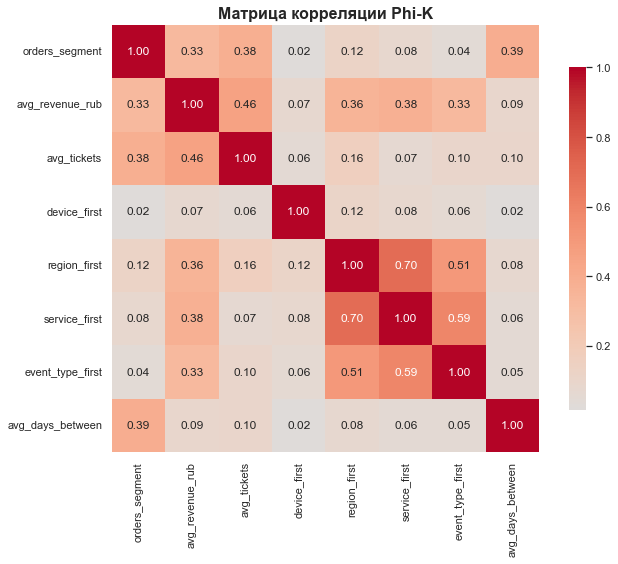

In [131]:
# Визуализация корреляции с total_orders
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_segmented, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляции Phi-K', fontsize=16, fontweight='bold')
plt.tight_layout()

**Наибольшая связь с количеством заказов:**


- Средний интервал между заказами (0.391) - самая сильная связь

- Среднее количество билетов (0.383) - второй по важности

- Средняя выручка с заказа (0.325) - умеренная связь


*Вывод:*


Пользователи, которые делают больше заказов, обычно:

    - Имеют более регулярные интервалы между покупками
    - Покупают больше билетов в одном заказе
    - Тратят больше денег в среднем за заказ

**Показатели, которые слабо или совсем не влияют на количество заказов:**
- Регион (0.124) - очень слабая связь

- Билетный оператор (0.082) - минимальная связь

- Тип мероприятия (0.041) - практически отсутствует

- Тип устройства (0.017) - практически отсутствует

*Вывод:*

Технические, географические характеристики первого заказа  и тип мероприятия практически не влияют на то, сколько всего заказов сделает пользователь.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Информация о данных и подготовка**
1. Исходные данные: 290,611 заказов от 21,838 пользователей

2. Подготовка данных:

- Удалено 1.12% строк (технические дубликаты, выбросы, возвраты)

- Конвертация валюты (тенге в рубли)

- Фильтрация выбросов по 99-му перцентилю

- Оптимизация типов данных для экономии памяти

**Основные результаты анализа**
1. Статистика пользователей
- Всего пользователей: 21,622

- 1 заказ: 38.7% пользователей

- 2-4 заказа: 33.0% пользователей

- 5+ заказов: 28.3% пользователей

- Общая доля возврата (2+ заказа): 61.3%


2. Признаки первого заказа, влияющие на возврат
- Устройство: Desktop-пользователи возвращаются чаще (63.8% vs 60.8%)

- Тип мероприятия: Выставки (64.2%) и театр (63.4%) лидируют

- Билетный оператор: "Край билетов" (65.2%) и "Дом культуры" (64.6%)

- Регион: Шанырский регион (67.3%) и Светополянский округ (65.7%)


3. Влияние финансовых показателей
- Средняя выручка: почти одинаковая у всех групп (~545 руб.)

- Количество билетов: КЛЮЧЕВОЙ показатель!

- 2-3 билета: 73.6% возврата (наилучший результат)

- 5+ билетов: 18.8% возврата (худший результат)


4. Временные характеристики
- День недели: значимо не влияет (разница всего 3.5%)

- Интервал между заказами: важен

- <1 недели: 45.3% пользователей

- 1-2 недели: 75.6% становятся постоянными клиентами


5. Корреляционный анализ (наиболее важные признаки)
- Средний интервал между заказами: 0.391 (самая сильная связь)

- Среднее количество билетов: 0.383

- Средняя выручка: 0.325

- Характеристики первого заказа: слабая связь (<0.13)


Поведенческие метрики (регулярность покупок, размер заказа) важнее, чем характеристики первого заказа для прогноза лояльности.

**Рекомендации для маркетинга**
1. Приоритетные сегменты
- Пользователи, покупающие 2-3 билета за раз

- Desktop-пользователи

- Посетители театров и выставок

- Клиенты билетных операторов "Край билетов" и "Дом культуры"

2. Стратегия удержания
- Оптимальный ритм коммуникации: через 1-2 недели после покупки

- Не беспокоить слишком часто (<1 недели) 

- Реактивация через 2 месяца если нет возврата

3. Маркетинговые действия

- Создать программу лояльности для покупателей 2-3 билетов

- Не тратить ресурсы на оптимизацию по дням недели


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/NataliaOrlKosh/loyalty_analysis_afisha.git